In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import pandas as pd
import os.path
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

### Import and clean the data

In [3]:
# Load filelist into python list object files. Replace path_to_csvfiles with location of your files.
path_to_csvfiles = 'C:/Users/lylek/Documents/Wolf/Flow Testing Project/edc-test-data/CSVs/'
files = glob.glob(path_to_csvfiles+'*.csv')

# Import each CSV to a separate dataframe and store in python list dfs. Add a column for tester info.
dfs = []
for csv in files:
    frame = pd.read_csv(csv, header=None, skiprows=[0])
    dfs.append(frame)

# Concatenate all CSV data into one large dataframe, clean it up
df = pd.concat(dfs, ignore_index=True)
df.set_index(df[2], inplace=True)
df.drop(columns=[1,2,7,8,10,11,12,13,14,15], inplace=True)
df.rename(columns={0:'parameter', 3:'test', 4:'sn', 5:'model', 6:'tester', 9:'flowrate'}, inplace=True)
df.index = pd.to_datetime(df.index)

# Since timestamp only goes to the minute, we have duplicate index entries.
# Need to eliminate duplicates by adding milliseconds to the duplicated values
delta = pd.to_timedelta(df.groupby(level=0).cumcount(), unit='ms')
df.index = df.index + delta
df.index.rename('Date', inplace=True)

# Setting datatypes for remaining columns
df = df.astype({'parameter':'string', 'test':'string', 'flowrate':'float', 'tester':'string', 'sn':'int', 'model':'string'})

# Add a burner column and populate based on test column.
df['burner'] = df['test'].str.split('-|_').str[0]
df['burner'].replace(to_replace={'Burner15k':'15K', 
                                 'Burner9k':'9K', 
                                 'B1':'9K',
                                 'B2':'20K',                                 
                                 'B3':'15K',
                                 'B4':'18K',
                                 'B5':'15K',
                                 'B6':'18K'},
                     inplace=True)



# Add a line column and populate based on tester column
df.loc[df['tester'].str.startswith('SRT'), 'line'] = 'SRT'
df.loc[df['tester'].str.startswith('R'), 'line'] = 'GR'

# Set burnerLoc based on test column
df['burnerLoc'] = df['test'].str.extract('(B\d)')
df['burnerLoc'] = df['burnerLoc'].str.extract('(\d)')
# Create BTU column conversion
df['btu'] = round(df['flowrate'] * 2.117 * 1075)


# Create and populate main/simmer, high/low columns
df['main/simmer'] = np.nan
df['high/low'] = np.nan
df.loc[df['parameter'].str.contains('Mhf'), ['main/simmer', 'high/low']] = ['M','H']
df.loc[df['parameter'].str.contains('Shf'), ['main/simmer', 'high/low']] = ['S','H']
df.loc[df['test'].str.contains('mainH'), ['main/simmer', 'high/low']] = ['M','H']
df.loc[df['test'].str.contains('mainL'), ['main/simmer', 'high/low']] = ['M','L']
df.loc[df['test'].str.contains('simH'), ['main/simmer', 'high/low']] = ['S','H']
df.loc[df['test'].str.contains('simL'), ['main/simmer', 'high/low']] = ['S','L']

# Drop unneeded columns and na rows
df.drop(columns=['parameter','test'], inplace=True)

df.dropna(inplace=True)


### Set up filters and data subsets

In [4]:
gr = df['line'] == 'GR'
srt = df['line'] == 'SRT'

burner9k = df['burner'] == '9K'
burner15k = df['burner'] == '15K'
burner18k = df['burner'] == '18K'
burner20k = df['burner'] == '20K'

main = df['main/simmer'] == 'M'
simmer = df['main/simmer'] == 'S'
high = df['high/low'] == 'H'
low = df['high/low'] == 'L'

mainhigh = df[main & high]
mainlow = df[main & low]
simmerhigh = df[simmer & high]
simmerlow = df[simmer & low]

mainhigh9k = mainhigh[burner9k]
mainhigh15k = mainhigh[burner15k]
mainhigh18k = mainhigh[burner18k]
mainhigh20k = mainhigh[burner20k]

mainlow9k = mainlow[burner9k]
mainlow15k = mainlow[burner15k]
mainlow18k = mainlow[burner18k]
mainlow20k = mainlow[burner20k]

simmerhigh9k = simmerhigh[burner9k]
simmerhigh15k = simmerhigh[burner15k]
simmerhigh18k = simmerhigh[burner18k]
simmerhigh20k = simmerhigh[burner20k]

simmerlow9k = simmerlow[burner9k]
simmerlow15k = simmerlow[burner15k]
simmerlow18k = simmerlow[burner18k]
simmerlow20k = simmerlow[burner20k]

r8110 = df['tester'] == 'R8110'
r8140 = df['tester'] == 'R8140'
r8210 = df['tester'] == 'R8210'
r8240 = df['tester'] == 'R8240'
r8310 = df['tester'] == 'R8310'
srt350 = df['tester'] == 'SRT350'
srt380 = df['tester'] == 'SRT380'

# Current (12/2020) final tester limits for each burner by line
gr9klim = {'mh-lwr':3.799, 'mh-upr':5.027,
           'ml-lwr':None, 'ml-upr':None,
           'sh-lwr':0.605, 'sh-upr':1.157,
           'sl-lwr':None, 'sl-upr':None}

gr15klim = {'mh-lwr':6.193, 'mh-upr':8.062,
            'ml-lwr':None, 'ml-upr':None,
            'sh-lwr':0.997, 'sh-upr':1.719,
            'sl-lwr':None, 'sl-upr':None}

srt9klim = {'mh-lwr':3.875, 'mh-upr':5.418,
            'ml-lwr':0.200, 'ml-upr':0.680,
            'sh-lwr':0.520, 'sh-upr':1.000,
            'sl-lwr':0.100, 'sl-upr':0.600}

srt15klim = {'mh-lwr':6.506, 'mh-upr':8.045,
             'ml-lwr':0.500, 'ml-upr':1.000,
             'sh-lwr':1.000, 'sh-upr':1.600,
             'sl-lwr':0.300, 'sl-upr':0.800}

srt18klim = {'mh-lwr':8.328, 'mh-upr':10.460,
             'ml-lwr':0.500, 'ml-upr':1.000,
             'sh-lwr':1.000, 'sh-upr':1.600,
             'sl-lwr':0.300, 'sl-upr':0.800}

srt20klim = {'mh-lwr':8.031, 'mh-upr':11.621,
             'ml-lwr':0.490, 'ml-upr':1.040,
             'sh-lwr':1.000, 'sh-upr':1.626,
             'sl-lwr':0.300, 'sl-upr':0.820}



### Dropping outliers

In [5]:
from scipy import stats

mainhigh20k = mainhigh20k[(np.abs(stats.zscore(mainhigh20k['btu'])) < 3)]
mainhigh18k = mainhigh18k[(np.abs(stats.zscore(mainhigh18k['btu'])) < 3)]
mainhigh15k = mainhigh15k[(np.abs(stats.zscore(mainhigh15k['btu'])) < 3)]
mainhigh9k = mainhigh9k[(np.abs(stats.zscore(mainhigh9k['btu'])) < 3)]

mainlow20k = mainlow20k[(np.abs(stats.zscore(mainlow20k['btu'])) < 3)]
mainlow18k = mainlow18k[(np.abs(stats.zscore(mainlow18k['btu'])) < 3)]
mainlow15k = mainlow15k[(np.abs(stats.zscore(mainlow15k['btu'])) < 3)]
mainlow9k = mainlow9k[(np.abs(stats.zscore(mainlow9k['btu'])) < 3)]

simmerhigh20k = simmerhigh20k[(np.abs(stats.zscore(simmerhigh20k['btu'])) < 3)]
simmerhigh18k = simmerhigh18k[(np.abs(stats.zscore(simmerhigh18k['btu'])) < 3)]
simmerhigh15k = simmerhigh15k[(np.abs(stats.zscore(simmerhigh15k['btu'])) < 3)]
simmerhigh9k = simmerhigh9k[(np.abs(stats.zscore(simmerhigh9k['btu'])) < 3)]

simmerlow20k = simmerlow20k[(np.abs(stats.zscore(simmerlow20k['btu'])) < 3)]
simmerlow18k = simmerlow18k[(np.abs(stats.zscore(simmerlow18k['btu'])) < 3)]
simmerlow15k = simmerlow15k[(np.abs(stats.zscore(simmerlow15k['btu'])) < 3)]
simmerlow9k = simmerlow9k[(np.abs(stats.zscore(simmerlow9k['btu'])) < 3)]


### Plots

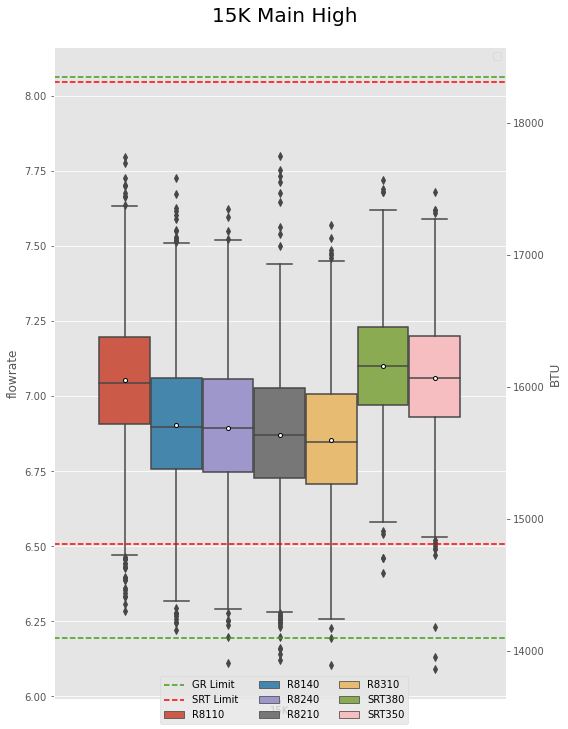

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,10))
fig.suptitle('15K Main High', y=1.0, fontsize=20)


sns.boxplot(ax=ax, 
            x = mainhigh15k['burner'], 
            y = 'flowrate', 
            data = mainhigh, 
            hue = 'tester', 
            showfliers=True,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"4"})

ax.axhline(y=gr15klim['mh-lwr'], ls='--', c='#3c9e12', label='GR Limit')
ax.axhline(y=gr15klim['mh-upr'], ls='--', c='#3c9e12')
ax.axhline(y=srt15klim['mh-lwr'], ls='--', c='r', label='SRT Limit')
ax.axhline(y=srt15klim['mh-upr'], ls='--', c='r')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines[:0], labels[:0])
fig.legend(loc='lower center', ncol=3)

def slpm2btu(x):
    return x * 2.117 * 1075


def btu2slpm(x):
    return x / 2.117 / 1075

secax = ax.secondary_yaxis('right', functions=(slpm2btu, btu2slpm))
secax.set_ylabel('BTU')
ax.set(xlabel=None)

plt.tight_layout()


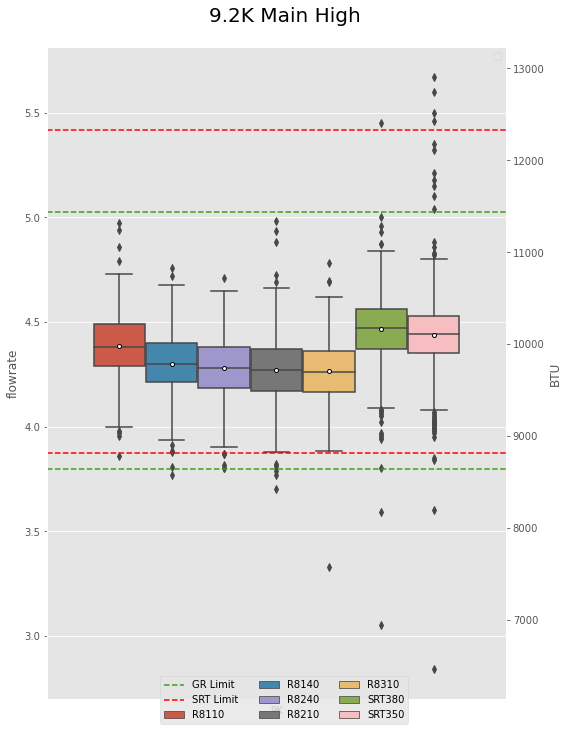

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,10))
fig.suptitle('9.2K Main High', y=1.0, fontsize=20)


sns.boxplot(ax=ax, 
            x = mainhigh9k['burner'], 
            y = 'flowrate', 
            data = mainhigh, 
            hue = 'tester', 
            showfliers=True,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"4"})

ax.axhline(y=gr9klim['mh-lwr'], ls='--', c='#3c9e12', label='GR Limit')
ax.axhline(y=gr9klim['mh-upr'], ls='--', c='#3c9e12')
ax.axhline(y=srt9klim['mh-lwr'], ls='--', c='r', label='SRT Limit')
ax.axhline(y=srt9klim['mh-upr'], ls='--', c='r')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines[:0], labels[:0])
fig.legend(loc='lower center', ncol=3)

def slpm2btu(x):
    return x * 2.117 * 1075


def btu2slpm(x):
    return x / 2.117 / 1075

secax = ax.secondary_yaxis('right', functions=(slpm2btu, btu2slpm))
secax.set_ylabel('BTU')
ax.set(xlabel=None)

plt.tight_layout()

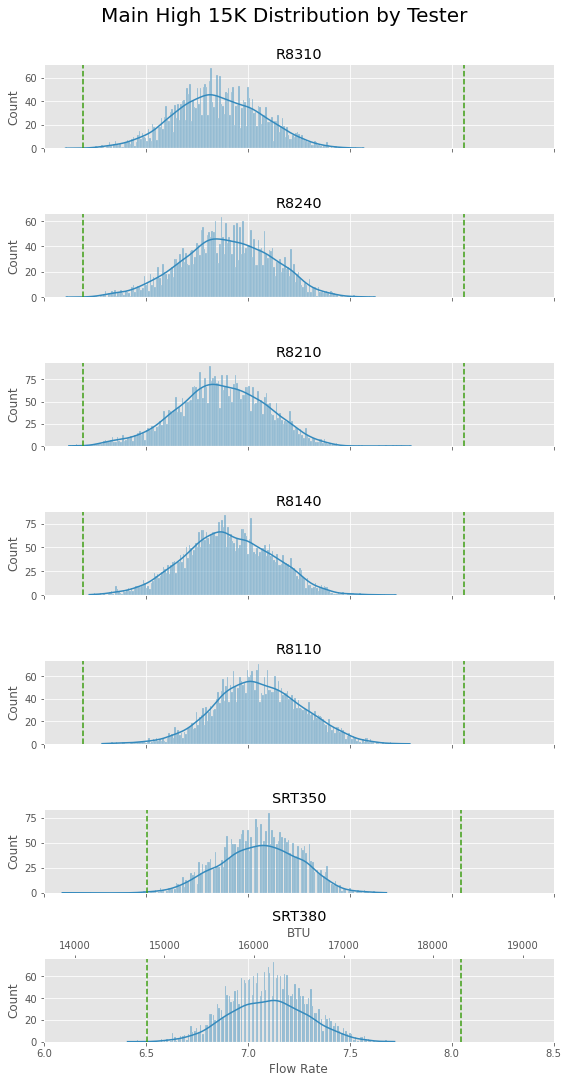

In [10]:
fig, axes = plt.subplots(7,1,sharex=True,figsize=(8,15))
fig.suptitle('Main High 15K Distribution by Tester', y=1, fontsize=20)
sns.histplot(mainhigh15k[r8310]['flowrate'], ax=axes[0], bins=200, kde=True)
sns.histplot(mainhigh15k[r8240]['flowrate'], ax=axes[1], bins=200, kde=True)
sns.histplot(mainhigh15k[r8210]['flowrate'], ax=axes[2], bins=200, kde=True)
sns.histplot(mainhigh15k[r8140]['flowrate'], ax=axes[3], bins=200, kde=True)
sns.histplot(mainhigh15k[r8110]['flowrate'], ax=axes[4], bins=200, kde=True)
sns.histplot(mainhigh15k[srt350]['flowrate'], ax=axes[5], bins=200, kde=True)
sns.histplot(mainhigh15k[srt380]['flowrate'], ax=axes[6], bins=200, kde=True)
plt.xlim(6, 8.5)


axes[0].axvline(x=gr15klim['mh-lwr'], ls='--', c='#3c9e12')
axes[0].axvline(x=gr15klim['mh-upr'], ls='--', c='#3c9e12')
axes[1].axvline(x=gr15klim['mh-lwr'], ls='--', c='#3c9e12')
axes[1].axvline(x=gr15klim['mh-upr'], ls='--', c='#3c9e12')
axes[2].axvline(x=gr15klim['mh-lwr'], ls='--', c='#3c9e12')
axes[2].axvline(x=gr15klim['mh-upr'], ls='--', c='#3c9e12')
axes[3].axvline(x=gr15klim['mh-lwr'], ls='--', c='#3c9e12')
axes[3].axvline(x=gr15klim['mh-upr'], ls='--', c='#3c9e12')
axes[4].axvline(x=gr15klim['mh-lwr'], ls='--', c='#3c9e12')
axes[4].axvline(x=gr15klim['mh-upr'], ls='--', c='#3c9e12')
axes[5].axvline(x=srt15klim['mh-lwr'], ls='--', c='#3c9e12')
axes[5].axvline(x=srt15klim['mh-upr'], ls='--', c='#3c9e12')
axes[6].axvline(x=srt15klim['mh-lwr'], ls='--', c='#3c9e12')
axes[6].axvline(x=srt15klim['mh-upr'], ls='--', c='#3c9e12')

axes[0].set_title('R8310')
axes[1].set_title('R8240')
axes[2].set_title('R8210')
axes[3].set_title('R8140')
axes[4].set_title('R8110')
axes[5].set_title('SRT350')
axes[6].set_title('SRT380')

plt.xlabel('Flow Rate')

def slpm2btu(x):
    return x * 2.117 * 1075


def btu2slpm(x):
    return x / 2.117 / 1075

secax = axes[6].secondary_xaxis('top', functions=(slpm2btu, btu2slpm))
secax.set_xlabel('BTU')

plt.tight_layout()
plt.show()


In [11]:
print(mainhigh15k['flowrate'].mean() - mainhigh15k['flowrate'].std()*3.5)
print(mainhigh15k['flowrate'].mean() + mainhigh15k['flowrate'].std()*3.5)

6.139869196837375
7.765410054568158


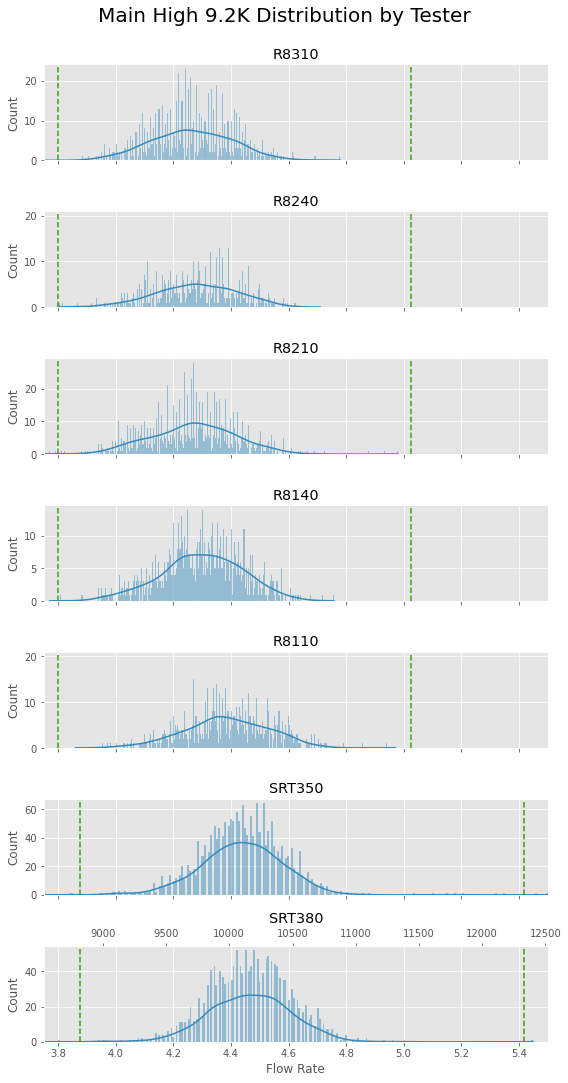

In [12]:
fig, axes = plt.subplots(7,1,sharex=True,figsize=(8,15))
fig.suptitle('Main High 9.2K Distribution by Tester', y=1, fontsize=20)
sns.histplot(mainhigh9k[r8310]['flowrate'], ax=axes[0], bins=400, kde=True)
sns.histplot(mainhigh9k[r8240]['flowrate'], ax=axes[1], bins=400, kde=True)
sns.histplot(mainhigh9k[r8210]['flowrate'], ax=axes[2], bins=400, kde=True)
sns.histplot(mainhigh9k[r8140]['flowrate'], ax=axes[3], bins=400, kde=True)
sns.histplot(mainhigh9k[r8110]['flowrate'], ax=axes[4], bins=400, kde=True)
sns.histplot(mainhigh9k[srt350]['flowrate'], ax=axes[5], bins=400, kde=True)
sns.histplot(mainhigh9k[srt380]['flowrate'], ax=axes[6], bins=400, kde=True)
plt.xlim(3.75, 5.5)


axes[0].axvline(x=gr9klim['mh-lwr'], ls='--', c='#3c9e12')
axes[0].axvline(x=gr9klim['mh-upr'], ls='--', c='#3c9e12')
axes[1].axvline(x=gr9klim['mh-lwr'], ls='--', c='#3c9e12')
axes[1].axvline(x=gr9klim['mh-upr'], ls='--', c='#3c9e12')
axes[2].axvline(x=gr9klim['mh-lwr'], ls='--', c='#3c9e12')
axes[2].axvline(x=gr9klim['mh-upr'], ls='--', c='#3c9e12')
axes[3].axvline(x=gr9klim['mh-lwr'], ls='--', c='#3c9e12')
axes[3].axvline(x=gr9klim['mh-upr'], ls='--', c='#3c9e12')
axes[4].axvline(x=gr9klim['mh-lwr'], ls='--', c='#3c9e12')
axes[4].axvline(x=gr9klim['mh-upr'], ls='--', c='#3c9e12')
axes[5].axvline(x=srt9klim['mh-lwr'], ls='--', c='#3c9e12')
axes[5].axvline(x=srt9klim['mh-upr'], ls='--', c='#3c9e12')
axes[6].axvline(x=srt9klim['mh-lwr'], ls='--', c='#3c9e12')
axes[6].axvline(x=srt9klim['mh-upr'], ls='--', c='#3c9e12')

# axes[0].axvline(x=6.14, ls='--', c='r')
# axes[0].axvline(x=7.76, ls='--', c='r')
# axes[1].axvline(x=6.14, ls='--', c='r')
# axes[1].axvline(x=7.76, ls='--', c='r')
# axes[2].axvline(x=6.14, ls='--', c='r')
# axes[2].axvline(x=7.76, ls='--', c='r')
# axes[3].axvline(x=6.14, ls='--', c='r')
# axes[3].axvline(x=7.76, ls='--', c='r')
# axes[4].axvline(x=6.14, ls='--', c='r')
# axes[4].axvline(x=7.76, ls='--', c='r')
# axes[5].axvline(x=6.14, ls='--', c='r')
# axes[5].axvline(x=7.76, ls='--', c='r')
# axes[6].axvline(x=6.14, ls='--', c='r')
# axes[6].axvline(x=7.76, ls='--', c='r')

axes[0].set_title('R8310')
axes[1].set_title('R8240')
axes[2].set_title('R8210')
axes[3].set_title('R8140')
axes[4].set_title('R8110')
axes[5].set_title('SRT350')
axes[6].set_title('SRT380')

plt.xlabel('Flow Rate')

def slpm2btu(x):
    return x * 2.117 * 1075


def btu2slpm(x):
    return x / 2.117 / 1075

secax = axes[6].secondary_xaxis('top', functions=(slpm2btu, btu2slpm))
#secax.set_xlabel('BTU')

plt.tight_layout()
plt.show()


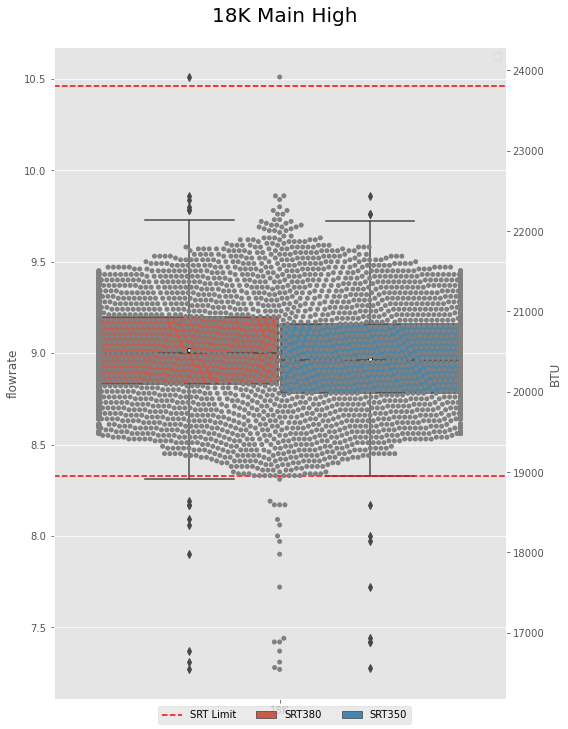

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8,10))
fig.suptitle('18K Main High', y=1.0, fontsize=20)


sns.boxplot(ax=ax, 
            x = 'burner', 
            y = 'flowrate', 
            data = mainhigh18k[srt],
            hue = 'tester' ,
            showfliers=True,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"4"})
sns.swarmplot(x='burner', y='flowrate', data=mainhigh18k[srt], color="grey", ax=ax)

ax.axhline(y=srt18klim['mh-lwr'], ls='--', c='r', label='SRT Limit')
ax.axhline(y=srt18klim['mh-upr'], ls='--', c='r')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines[:0], labels[:0])
fig.legend(loc='lower center', ncol=3)

def slpm2btu(x):
    return x * 2.117 * 1075


def btu2slpm(x):
    return x / 2.117 / 1075

secax = ax.secondary_yaxis('right', functions=(slpm2btu, btu2slpm))
secax.set_ylabel('BTU')
ax.set(xlabel=None)

plt.tight_layout()


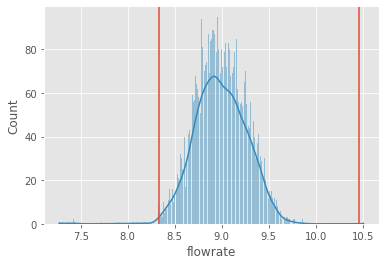

In [19]:
sns.histplot(mainhigh18k['flowrate'], bins=400, kde=True)
plt.axvline(x=srt18klim['mh-lwr'])
plt.axvline(x=srt18klim['mh-upr'])

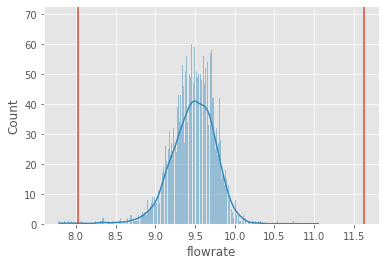

In [20]:
sns.histplot(mainhigh20k['flowrate'], bins=400, kde=True)
plt.axvline(x=srt20klim['mh-upr'])
plt.axvline(x=srt20klim['mh-lwr'])

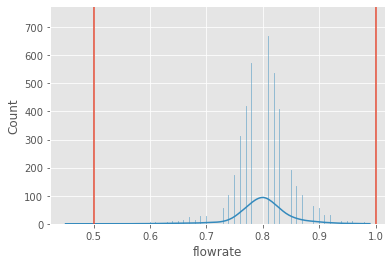

In [21]:
sns.histplot(mainlow18k['flowrate'], bins=400, kde=True)
plt.axvline(x=srt18klim['ml-upr'])
plt.axvline(x=srt18klim['ml-lwr'])

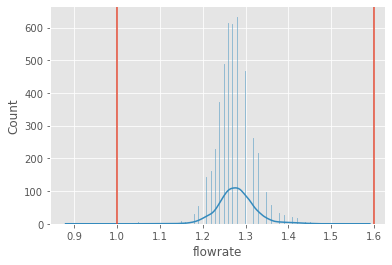

In [22]:
sns.histplot(simmerhigh18k['flowrate'], bins=400, kde=True)
plt.axvline(x=srt18klim['sh-upr'])
plt.axvline(x=srt18klim['sh-lwr'])